In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

In [4]:
mapillary_coverage_23_bb = gpd.read_parquet("mapillary_coverage_23_bb.parquet")
#mapillary_coverage_23_bb.plot()

mapillary_coverage_23_bb

,geometry,captured_at,creator_id,id,image_id,is_pano,organization_id
0,"LINESTRING (11.25 53.48816, 11.25001 53.48816,...",2023-08-08,1.059060e+14,3qWaopnmx0Hg84duJlRMvs,5.600373e+14,False,NaN
1,"LINESTRING (11.25 53.48816, 11.25033 53.48815,...",2024-08-25,1.036070e+14,V7Y9Kyudnkh6WZCfTecHai,2.232804e+15,False,NaN
2,"LINESTRING (11.25597 53.48805, 11.25571 53.488...",2024-08-17,1.036070e+14,w96aFGSQ3yq8ZxuPop7siW,7.845101e+15,False,NaN
3,"LINESTRING (11.25527 53.48805, 11.25416 53.488...",2023-08-30,1.005241e+14,bZJvRiFE2yeCYV0tsIHKU8,8.473513e+14,False,NaN
4,"LINESTRING (11.25 53.48821, 11.25041 53.4882, ...",2023-07-15,1.029764e+14,reRiOBw82C7HSInPsa3cDp,1.905719e+14,False,NaN
...,...,...,...,...,...,...,...
123568,"LINESTRING (14.76659 51.56341, 14.76656 51.563...",2023-04-29,1.096899e+14,7G06OKMJgzsZpF4HiBcNd1,9.047768e+14,False,NaN
123569,"MULTILINESTRING ((14.77453 51.5422, 14.77454 5...",2024-04-14,1.071818e+14,nRjv6sPAXi9CowIelB4r2S,4.444892e+14,False,NaN
123570,"LINESTRING (14.77444 51.54219, 14.77444 51.542...",2024-04-14,1.071818e+14,JQzE5olUVSLFfOtKkag9GN,1.473379e+15,False,NaN
123571,"LINESTRING (14.77977 51.5099, 14.78022 51.5097...",2024-05-31,1.092948e+14,NHx4eIw2BcnPWvLQOYhF0A,4.713430e+14,False,NaN


<Axes: >

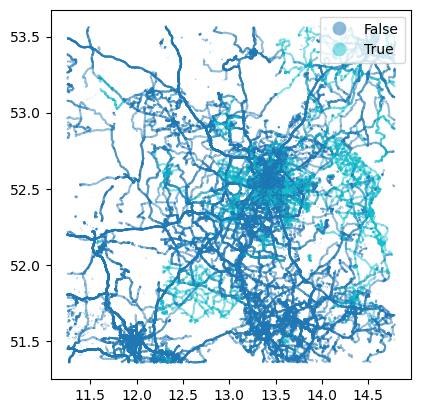

In [5]:
mapillary_coverage_23_bb.plot(column="is_pano",alpha=0.5, legend=True)

In [27]:
# takes a while to run ~ 6min
# first buffer then dissolve

#mapillary_coverage_23_bb = gpd.read_parquet("mapillary_coverage_23_bb.parquet")

#sample=mapillary_coverage_23_bb[:6000].copy()
#sample=mapillary_coverage_23_bb[:1000].copy()

# expolde the geometry to make buffering faster
mapillary_coverage_23_bb_exploded = mapillary_coverage_23_bb.explode(index_parts=False, ignore_index=True)

# create 10m buffers for all the lines
mapillary_coverage_23_bb_buffered = mapillary_coverage_23_bb_exploded.to_crs(25832).copy()
mapillary_coverage_23_bb_buffered['geometry'] = mapillary_coverage_23_bb_buffered['geometry'].buffer(10)

# dissolve the buffered geometries for pano and non-pano
mapillary_coverage_23_bb_buffered_diss = mapillary_coverage_23_bb_buffered.dissolve(by="is_pano")


In [28]:
#keep=mapillary_coverage_23_bb_buffered_diss.copy()

In [29]:
mapillary_coverage_23_bb_buffered_diss=mapillary_coverage_23_bb_buffered_diss.reset_index()
mapillary_coverage_23_bb_buffered_diss.to_parquet("mapillary_coverage_23_bb_buffered10m_dissolved.parquet")

In [30]:
mapillary_coverage_23_bb_buffered=mapillary_coverage_23_bb_buffered.reset_index()
mapillary_coverage_23_bb_buffered.to_parquet("mapillary_coverage_23_bb_buffered10m_ndissolved.parquet")

### some performance tests

In [ ]:
## alternative: explode the multilinestrings only
### its exactly the same speed

def explode_multilines(gdf):
    multi = gdf[gdf.geometry.type == 'MultiLineString']
    single = gdf[gdf.geometry.type != 'MultiLineString']
    exploded = multi.explode(index_parts=False, ignore_index=True)
    return pd.concat([single, exploded], ignore_index=True)

# expolde the geometry to make buffering faster
mapillary_coverage_23_bb_exploded = explode_multilines(mapillary_coverage_23_bb)
#mapillary_coverage_23_bb_exploded = mapillary_coverage_23_bb.explode(index_parts=False, ignore_index=True)

# create 10m buffers for all the lines
mapillary_coverage_23_bb_buffered = mapillary_coverage_23_bb_exploded.to_crs(25832).copy()
mapillary_coverage_23_bb_buffered['geometry'] = mapillary_coverage_23_bb_buffered['geometry'].buffer(10)

# dissolve the buffered geometries for pano and non-pano
mapillary_coverage_23_bb_buffered_diss = mapillary_coverage_23_bb_buffered.dissolve(by="is_pano")

In [ ]:
## try with dask
## this is not faster but still not really understood
### takes ~ 7min

import geopandas as gpd
import shapely
import dask
from dask import delayed
from dask.distributed import Client
import pandas as pd

# Start Dask client
client = Client()
print(client.dashboard_link)

# Load your data
gdf = gpd.read_parquet("mapillary_coverage_23_bb.parquet")
gdf = gdf.explode(index_parts=False, ignore_index=True)
gdf = gdf.to_crs(25832)

# Split into chunks manually
def buffer_chunk(chunk):
    chunk = chunk.copy()
    chunk['geometry'] = shapely.buffer(chunk['geometry'].values, 10)
    return chunk

# Chunk size
chunk_size = 10_000
chunks = [gdf.iloc[i:i + chunk_size] for i in range(0, len(gdf), chunk_size)]

# Wrap each chunk in delayed
buffered_chunks = [delayed(buffer_chunk)(chunk) for chunk in chunks]

# Compute all chunks
buffered_results = dask.compute(*buffered_chunks)

# Combine all buffered results
buffered_df = pd.concat(buffered_results, ignore_index=True)
buffered_gdf = gpd.GeoDataFrame(buffered_df, geometry='geometry', crs=gdf.crs)

# Dissolve by "is_pano"
buffered_diss = buffered_gdf.dissolve(by="is_pano")


c:\Users\simon\anaconda3\envs\tempo30_new\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62431 instead
  warnings.warn(
c:\Users\simon\anaconda3\envs\tempo30_new\Lib\site-packages\distributed\client.py:3383: UserWarning: Sending large graph of size 166.86 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [14]:
buffered_diss


,geometry,captured_at,creator_id,id,image_id,organization_id
is_pano,,,,,,
False,"MULTIPOLYGON (((658148.636 5692083.449, 658146...",2023-08-08,1.059060e+14,3qWaopnmx0Hg84duJlRMvs,5.600373e+14,4.272651e+14
True,"MULTIPOLYGON (((710149.54 5694133.065, 710148....",2023-02-02,1.014800e+14,YUpyLmhqz8A0dMCrk1cSQi,1.583684e+15,3.192697e+14


In [20]:
buffered_diss=buffered_diss.reset_index()

AttributeError: 'function' object has no attribute 'reset_index'

In [19]:
buffered_diss[buffered_diss["is_pano"]==True].plot()

TypeError: 'method' object is not subscriptable